Evaluate Japanese tokenization using Amazon esci-data

Pre-requirement

* git clone esci-data
* Start Weaviate server

Index products to Weaviate

* only product_title

With GSE tokenization and Kagome JA tokenization.

1. create collection with GSE
2. index product_title and product_id



In [7]:
import os
import json
import weaviate
from weaviate.classes.config import Property, DataType, Tokenization, Configure

# initialize weaviate client
client = weaviate.connect_to_local(
    #host="weaviate",
    host="host.docker.internal",
)
if client.is_ready():
    print("Connected Weaviate server!")

# Create collection with tokenization properties
collection_name = "products"

if client.collections.exists(name=collection_name) == False :
    client.collections.create(
        name=collection_name,
        properties=[
            Property(
                name="product_id",
                data_type=DataType.TEXT,
                skip_vectorization=True,
                index_filterable=True,
                index_searchable=True
            ),
            Property(
                name="title_gse",
                data_type=DataType.TEXT,
                tokenization=Tokenization.GSE,
                skip_vectorization=True,
                index_filterable=True,
                index_searchable=True
            ),
            Property(
                name="title_kagome",
                data_type=DataType.TEXT,
                tokenization=Tokenization.KAGOME_JA,
                skip_vectorization=True,
                index_filterable=True,
                index_searchable=True
            )
        ],
        vectorizer_config=Configure.Vectorizer.none(),
        vector_index_config=Configure.VectorIndex.none()
    )

# Check collection schema
collection = client.collections.get(
    name=collection_name
)
print(collection)


Connected Weaviate server!
<weaviate.Collection config={
  "name": "Products",
  "description": null,
  "generative_config": null,
  "inverted_index_config": {
    "bm25": {
      "b": 0.75,
      "k1": 1.2
    },
    "cleanup_interval_seconds": 60,
    "index_null_state": false,
    "index_property_length": false,
    "index_timestamps": false,
    "stopwords": {
      "preset": "en",
      "additions": null,
      "removals": null
    }
  },
  "multi_tenancy_config": {
    "enabled": false,
    "auto_tenant_creation": false,
    "auto_tenant_activation": false
  },
  "properties": [
    {
      "name": "product_id",
      "description": null,
      "data_type": "text",
      "index_filterable": true,
      "index_range_filters": false,
      "index_searchable": true,
      "nested_properties": null,
      "tokenization": "word",
      "vectorizer_config": null,
      "vectorizer": "none"
    },
    {
      "name": "title_gse",
      "description": null,
      "data_type": "text",
   

In [8]:
import pandas as pd

df_products = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet')
df_products = df_products[df_products["product_locale"] == "jp"]

print(f"# of products = {len(df_products)}")

# of products = 339059


In [9]:
counter = 0
interval = 100000

collection = client.collections.get(
    name=collection_name
)

#with collection.batch.rate_limit(requests_per_minute=500) as batch:
with collection.batch.dynamic() as batch:
    for row in df_products.itertuples():
        if batch.number_errors > 10:
            pass
        product = row._asdict()
        properties = {
            "product_id": product["product_id"],
            "title_gse": product["product_title"],
            "title_kagome": product["product_title"]
        }
        batch.add_object(
            properties=properties
        )
        counter += 1
        if counter % interval == 0:
            print(f"Imported {counter} articles...")
    if batch.number_errors != 0 and len(client.batch.failed_objects) == batch.number_errors:
        print(f"Error during batch execution. {batch.number_errors} errors...")
    else :
        print(f"Finished importing {counter} articles.")



/workspace/.venv/lib/python3.12/site-packages/weaviate/warnings.py:303: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/usr/local/lib/python3.12/asyncio/selector_events.py:879: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=84 read=idle write=<idle, bufsize=0>>
  _warn(f"unclosed transport {self!r}", ResourceWarning, source=self)


Imported 100000 articles...
Imported 200000 articles...
Imported 300000 articles...
Finished importing 339059 articles.


In [10]:

collection.aggregate.over_all(total_count=True).total_count

339059

Prepare quries and judgements data

In [11]:
df_examples = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_examples = df_examples[df_examples["product_locale"] == "jp"]
df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)
# query, query_id
queries: dict[str, str] = {}
# query_id, list(product_id, esci_label, split)
examples: dict[str, list[dict]] = {}

for row in df_examples_products.itertuples():
    product = row._asdict()
    tmp_query = product["query"]
    tmp_query_id = product["query_id"]
    queries[tmp_query_id] = tmp_query
    examples.setdefault(tmp_query_id, [])
    examples[tmp_query_id].append({
        "product_id": product["product_id"],
        "esci_label": product["esci_label"],
        "split": product["split"]
    })

print(f"Load {len(queries)} queries")


Load 18127 queries


Keyword search with Title

In [24]:
from weaviate.classes.query import MetadataQuery

k = 200

# filetr examples by esci_label == E
def exact_relevant_products(examples: list[dict]) -> list:
    relevants = []
    for item in examples:
        if item["esci_label"] == "E":
            relevants.append(item["product_id"])
    return relevants

# calculate recall @ k
def calc_recall(results: list, relevants: list) -> float:
    hits = 0
    for item in results:
        if item.properties["product_id"] in relevants:
            hits = hits+1
    return round(hits / len(relevants), 4)
    
# calculate precision @ k
def calc_precision(results: list, relevants: list) -> float:
    if not results:
        return 0.0
    hits = 0
    for item in results:
        if item.properties["product_id"] in relevants:
            hits = hits+1
    return round(hits / len(results), 4)

# count esci_label category
def count_esci_labels(labels:list) -> str:
    e = s = c = i = 0 
    for label in labels:
        if label["esci_label"] == "E":
            e = e+1
        elif label["esci_label"] == "S":
            s = s+1
        elif label["esci_label"] == "C":
            c = c+1
        elif label["esci_label"] == "I":
            i = i+1
    return f"E:{e}, S:{s}, C:{c}, I:{i}"


def debug_print(query, response, examples, relevants ,recall, precision):
    print(f"query [{query}]")
    print(f"# of objects : {len(response.objects)}")
    print(f"# of relevants : {len(examples[query_id])}")
    print(f"# of relevants : {len(relevants)}")
    print(f"recall    : {recall}")
    print(f"precision : {precision}")


def calculate_stats(queries, examples, collection, field) -> list[dict]:
    stats: list[dict] = []
    for (query_id, query) in queries.items():
        response = collection.query.bm25(
            query=query,
            query_properties=[field],
            return_metadata=MetadataQuery(score=True),
            limit=k
        )
        relevants = exact_relevant_products(examples=examples[query_id])
        recall = calc_recall(results=response.objects, relevants=relevants)
        precision = calc_precision(results=response.objects, relevants=relevants)
        
        stats.append(
            {
                "query": query,
                "query_id": query_id,
                "k": k,
                "num_of_hits": len(response.objects),
                "num_of_relevants": len(relevants),
                "num_of_examples": len(examples[query_id]),
                "num_of_esci_labels": count_esci_labels(labels=examples[query_id]),
                "recall": recall,
                "precision": precision
            }
        )
    return stats


# Recall / Precision for GSE

In [25]:

field = "title_gse"

stats_gse = calculate_stats(queries=queries, examples=examples, collection=collection, field=field)

pd_stats_gse = pd.DataFrame(stats_gse)
pd_stats_gse



,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
0,&ハニー シャンプー,116,200,200,19,40,"E:19, S:20, C:1, I:0",0.4737,0.045
1,'74ジェイルブレイク ac/dc,123,200,200,8,8,"E:8, S:0, C:0, I:0",0.8750,0.035
2,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,190,200,200,1,40,"E:1, S:7, C:0, I:32",1.0000,0.005
3,(知っていることはあまりないけれど)家族です,191,200,200,1,40,"E:1, S:2, C:0, I:37",1.0000,0.005
4,- ビニール手袋粉なし,295,200,200,29,40,"E:29, S:11, C:0, I:0",0.8276,0.120
...,...,...,...,...,...,...,...,...,...
18122,ﾎﾙｽﾀｰ,130647,200,200,15,16,"E:15, S:0, C:1, I:0",0.0000,0.000
18123,ﾏｼﾞｯｸﾘﾝ,130648,200,200,16,16,"E:16, S:0, C:0, I:0",0.0000,0.000
18124,ﾒｽﾃｨﾝ,130649,200,200,11,16,"E:11, S:0, C:5, I:0",0.0000,0.000
18125,ﾚﾃﾞｨｰｽ水着,130650,200,200,16,16,"E:16, S:0, C:0, I:0",0.0000,0.000


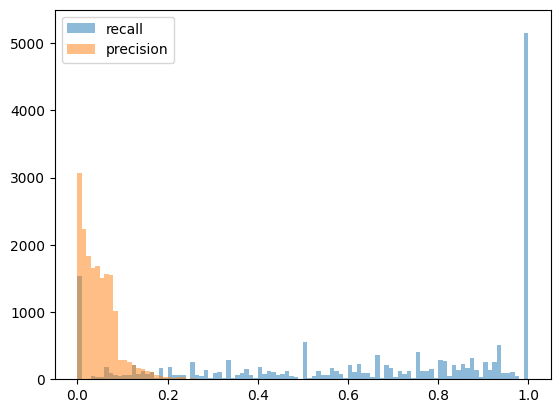

reacll describe.....
count    18127.000000
mean         0.647699
std          0.347901
min          0.000000
25%          0.363600
50%          0.750000
75%          1.000000
max          1.000000
Name: recall, dtype: float64
precision describe.....
count    18127.000000
mean         0.049369
std          0.062459
min          0.000000
25%          0.015000
50%          0.040000
75%          0.070000
max          1.000000
Name: precision, dtype: float64


,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
10869,ホウ酸,123384,200,10,16,16,"E:16, S:0, C:0, I:0",0.6250,1.0
13242,切腹,125757,200,1,1,16,"E:1, S:11, C:0, I:4",1.0000,1.0
14837,明恵,127353,200,15,16,16,"E:16, S:0, C:0, I:0",0.9375,1.0
15055,柳原白蓮,127571,200,14,15,16,"E:15, S:0, C:0, I:1",0.9333,1.0
15377,江副,127893,200,4,7,16,"E:7, S:3, C:0, I:6",0.5714,1.0
15537,清塚 信也,128053,200,1,16,16,"E:16, S:0, C:0, I:0",0.0625,1.0
15933,番線,128449,200,5,5,16,"E:5, S:6, C:0, I:5",1.0000,1.0
17533,雁が音,130054,200,2,10,16,"E:10, S:4, C:0, I:2",0.2000,1.0
17774,頭陀袋,130295,200,8,9,16,"E:9, S:7, C:0, I:0",0.8889,1.0
17906,鬼平,130428,200,16,16,16,"E:16, S:0, C:0, I:0",1.0000,1.0


In [26]:
import matplotlib.pyplot as plt

plt.hist(pd_stats_gse["recall"], bins=100, label="recall", alpha=0.5)
plt.hist(pd_stats_gse["precision"], bins=100, label="precision", alpha=0.5)
plt.ylim(0, 5500)
plt.legend()
plt.show()

print("reacll describe.....")
print(pd_stats_gse["recall"].describe())
print("precision describe.....")
print(pd_stats_gse["precision"].describe())
pd_stats_gse[pd_stats_gse["precision"] == 1.0]

In [28]:

pd_stats_gse[pd_stats_gse["recall"] == 0.0]

,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
13,0係,607,200,200,4,16,"E:4, S:8, C:0, I:4",0.0,0.0
20,1/18 ｲｸﾞﾆｯｼｮﾝﾓﾃﾞﾙ ｿｱﾗ,1041,200,200,12,16,"E:12, S:4, C:0, I:0",0.0,0.0
38,10禁すないぱー,1685,200,200,6,40,"E:6, S:26, C:0, I:8",0.0,0.0
44,125ｄ26ｌ,1950,200,200,5,16,"E:5, S:0, C:0, I:11",0.0,0.0
55,15ミリカラコン度なし,2216,200,200,7,40,"E:7, S:32, C:0, I:1",0.0,0.0
...,...,...,...,...,...,...,...,...,...
18122,ﾎﾙｽﾀｰ,130647,200,200,15,16,"E:15, S:0, C:1, I:0",0.0,0.0
18123,ﾏｼﾞｯｸﾘﾝ,130648,200,200,16,16,"E:16, S:0, C:0, I:0",0.0,0.0
18124,ﾒｽﾃｨﾝ,130649,200,200,11,16,"E:11, S:0, C:5, I:0",0.0,0.0
18125,ﾚﾃﾞｨｰｽ水着,130650,200,200,16,16,"E:16, S:0, C:0, I:0",0.0,0.0


# Recall / Precision for Kagome JA

In [27]:

field = "title_kagome"

stats_kagome = calculate_stats(queries=queries, examples=examples, collection=collection, field=field)

pd_stats_kagome = pd.DataFrame(stats_kagome)
pd_stats_kagome



,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
0,&ハニー シャンプー,116,200,200,19,40,"E:19, S:20, C:1, I:0",0.2105,0.020
1,'74ジェイルブレイク ac/dc,123,200,200,8,8,"E:8, S:0, C:0, I:0",1.0000,0.040
2,(マックバースト） mach burst 軽い コンフォート 穴開き スポーツ サドル 痛く...,190,200,200,1,40,"E:1, S:7, C:0, I:32",1.0000,0.005
3,(知っていることはあまりないけれど)家族です,191,200,200,1,40,"E:1, S:2, C:0, I:37",1.0000,0.005
4,- ビニール手袋粉なし,295,200,200,29,40,"E:29, S:11, C:0, I:0",0.9310,0.135
...,...,...,...,...,...,...,...,...,...
18122,ﾎﾙｽﾀｰ,130647,200,0,15,16,"E:15, S:0, C:1, I:0",0.0000,0.000
18123,ﾏｼﾞｯｸﾘﾝ,130648,200,0,16,16,"E:16, S:0, C:0, I:0",0.0000,0.000
18124,ﾒｽﾃｨﾝ,130649,200,0,11,16,"E:11, S:0, C:5, I:0",0.0000,0.000
18125,ﾚﾃﾞｨｰｽ水着,130650,200,200,16,16,"E:16, S:0, C:0, I:0",0.3750,0.030


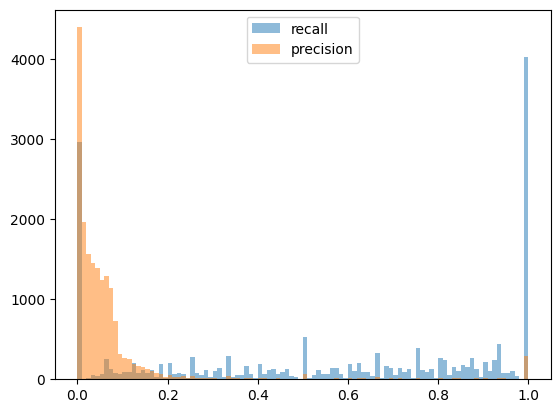

reacll describe.....
count    18127.000000
mean         0.558558
std          0.377273
min          0.000000
25%          0.187500
50%          0.625000
75%          0.937500
max          1.000000
Name: recall, dtype: float64
precision describe.....
count    18127.000000
mean         0.078620
std          0.167342
min          0.000000
25%          0.010000
50%          0.035000
75%          0.070000
max          1.000000
Name: precision, dtype: float64


,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
430,ajew エジュー,7664,200,10,16,16,"E:16, S:0, C:0, I:0",0.6250,1.0
500,analogman,8966,200,2,13,16,"E:13, S:2, C:0, I:1",0.1538,1.0
519,ankle brace,9288,200,1,16,16,"E:16, S:0, C:0, I:0",0.0625,1.0
571,artek,10519,200,9,12,15,"E:12, S:2, C:1, I:0",0.7500,1.0
591,attag,11020,200,2,2,8,"E:2, S:4, C:0, I:2",1.0000,1.0
...,...,...,...,...,...,...,...,...,...
17774,頭陀袋,130295,200,8,9,16,"E:9, S:7, C:0, I:0",0.8889,1.0
17868,高下駄,130390,200,3,8,16,"E:8, S:7, C:0, I:1",0.3750,1.0
17906,鬼平,130428,200,16,16,16,"E:16, S:0, C:0, I:0",1.0000,1.0
17949,鳩山郁子,130471,200,1,14,16,"E:14, S:1, C:0, I:1",0.0714,1.0


In [19]:
import matplotlib.pyplot as plt

plt.hist(pd_stats_kagome["recall"], bins=100, label="recall", alpha=0.5)
plt.hist(pd_stats_kagome["precision"], bins=100, label="precision", alpha=0.5)
plt.ylim(0, 5500)
plt.legend()
plt.show()

print("reacll describe.....")
print(pd_stats_kagome["recall"].describe())
print("precision describe.....")
print(pd_stats_kagome["precision"].describe())
pd_stats_kagome[pd_stats_kagome["precision"] == 1.0]

In [29]:
pd_stats_kagome[pd_stats_kagome["recall"] == 0.0]

,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
11,00g 目立たない,482,200,200,18,40,"E:18, S:20, C:0, I:2",0.0,0.0
13,0係,607,200,200,4,16,"E:4, S:8, C:0, I:4",0.0,0.0
29,100l,1497,200,200,12,12,"E:12, S:0, C:0, I:0",0.0,0.0
38,10禁すないぱー,1685,200,200,6,40,"E:6, S:26, C:0, I:8",0.0,0.0
55,15ミリカラコン度なし,2216,200,200,7,40,"E:7, S:32, C:0, I:1",0.0,0.0
...,...,...,...,...,...,...,...,...,...
18121,ﾎｯﾄサンドメーカー,130646,200,0,37,40,"E:37, S:3, C:0, I:0",0.0,0.0
18122,ﾎﾙｽﾀｰ,130647,200,0,15,16,"E:15, S:0, C:1, I:0",0.0,0.0
18123,ﾏｼﾞｯｸﾘﾝ,130648,200,0,16,16,"E:16, S:0, C:0, I:0",0.0,0.0
18124,ﾒｽﾃｨﾝ,130649,200,0,11,16,"E:11, S:0, C:5, I:0",0.0,0.0


In [33]:
pd_stats_gse[pd_stats_gse["num_of_hits"]==0]


,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
12981,佐分利信,125496,200,0,6,16,"E:6, S:9, C:0, I:1",0.0,0.0
15030,松生恒夫,127546,200,0,28,40,"E:28, S:8, C:0, I:4",0.0,0.0
15098,梶浦由記,127614,200,0,12,16,"E:12, S:3, C:0, I:1",0.0,0.0
15672,熊倉隆敏,128188,200,0,19,40,"E:19, S:16, C:0, I:5",0.0,0.0
16086,石持浅海,128605,200,0,16,38,"E:16, S:9, C:0, I:13",0.0,0.0
16537,胃薬,129057,200,0,16,16,"E:16, S:0, C:0, I:0",0.0,0.0
16726,芳沢光雄,129246,200,0,15,16,"E:15, S:0, C:0, I:1",0.0,0.0
17427,長島 康二,129948,200,0,5,8,"E:5, S:0, C:0, I:3",0.0,0.0


In [34]:
pd_stats_kagome[pd_stats_kagome["num_of_hits"]==0]


,query,query_id,k,num_of_hits,num_of_relevants,num_of_examples,num_of_esci_labels,recall,precision
372,aaa,6023,200,0,14,16,"E:14, S:0, C:0, I:2",0.0,0.0
373,aaadvd,6028,200,0,15,16,"E:15, S:0, C:1, I:0",0.0,0.0
381,acg,6336,200,0,14,16,"E:14, S:2, C:0, I:0",0.0,0.0
384,actitop,6444,200,0,3,27,"E:3, S:16, C:5, I:3",0.0,0.0
386,acuball,6476,200,0,5,40,"E:5, S:8, C:1, I:26",0.0,0.0
...,...,...,...,...,...,...,...,...,...
18119,ﾊﾞﾀｰｹｰｽ,130644,200,0,16,16,"E:16, S:0, C:0, I:0",0.0,0.0
18121,ﾎｯﾄサンドメーカー,130646,200,0,37,40,"E:37, S:3, C:0, I:0",0.0,0.0
18122,ﾎﾙｽﾀｰ,130647,200,0,15,16,"E:15, S:0, C:1, I:0",0.0,0.0
18123,ﾏｼﾞｯｸﾘﾝ,130648,200,0,16,16,"E:16, S:0, C:0, I:0",0.0,0.0


### Example query_id zero hits on Kagome field

It looks like the lowercase issue on Kagome field.

In [35]:
df_examples_products[df_examples_products["query_id"] == 6023]

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split,product_title,product_description,product_bullet_point,product_brand,product_color
10957,142799,aaa,6023,B0851P5L5F,jp,E,0,1,train,AAA DOME TOUR 2019 +PLUS(DVD3枚組),None,None,None,None
10958,142800,aaa,6023,B083V3TRQ8,jp,E,0,1,train,AAA 15th Anniversary All Time Music Clip Best ...,None,None,None,None
10959,142801,aaa,6023,B0851P61SM,jp,E,0,1,train,AAA DOME TOUR 2019 +PLUS(Blu-ray Disc2枚組),None,None,None,None
10960,142802,aaa,6023,B083V2Y1BZ,jp,E,0,1,train,【Amazon.co.jp限定】AAA 15th Anniversary All Time ...,None,4988064964482,None,None
10961,142803,aaa,6023,B0851PG2RR,jp,E,0,1,train,AAA DOME TOUR 2019 +PLUS(Blu-ray2枚組+グッズ)(初回生産限定盤),None,None,None,None
10962,142804,aaa,6023,B0851PGD5H,jp,E,0,1,train,【Amazon.co.jp限定】AAA DOME TOUR 2019 +PLUS(Blu-r...,None,4988064929269,None,None
10963,142805,aaa,6023,B0851P81F6,jp,E,0,1,train,AAA DOME TOUR 2019 +PLUS(DVD3枚組+グッズ)(初回生産限定盤),None,None,None,None
10964,142806,aaa,6023,B083V2SKHD,jp,E,0,1,train,【Amazon.co.jp限定】AAA 15th Anniversary All Time ...,None,4988064964536,None,None
10965,142807,aaa,6023,B077M4J613,jp,E,0,1,train,AAA DOME TOUR 2017 -WAY OF GLORY-(DVD2枚組()スマプラ対応),None,None,None,None
10966,142808,aaa,6023,B081NP9DB1,jp,E,0,1,train,AAA TOUR 2013 Eighth Wonder,None,None,None,None


#### 以下、テスト・確認用のスクリプト

In [ ]:
df_examples = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_examples[df_examples["query_id"] == 1]

In [ ]:
import pandas as pd

df_examples = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_examples.parquet')
df_products = pd.read_parquet('/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_products.parquet')
df_sources = pd.read_csv("/workspace/esci-data/shopping_queries_dataset/shopping_queries_dataset_sources.csv")
df_products = df_products[df_products["product_locale"] == "jp"]
df_examples = df_examples[df_examples["product_locale"] == "jp"]
df_examples_products = pd.merge(
    df_examples,
    df_products,
    how='left',
    left_on=['product_locale','product_id'],
    right_on=['product_locale', 'product_id']
)
df_examples_products_source = pd.merge(
    df_examples_products,
    df_sources,
    how='left',
    left_on=['query_id'],
    right_on=['query_id']
)
#df_examples_products_source["esci_label"].unique().tolist()
df_examples_products_source[df_examples_products_source["split"] == "test"]

# initialize weaviate client
client = weaviate.connect_to_local(
    host="weaviate",
    headers={
        "X-Google-Studio-Api-Key": os.getenv("GOOGLE_APIKEY")
    }
)
if client.is_ready():
    print("Connected Weaviate server!")

# Create collection with tokenization properties
collection_name = "products"

if client.collections.exists(name=collection_name) == False :
    client.collections.create(
        name=collection_name,
        vectorizer_config=[
            Configure.NamedVectors.text2vec_palm(
                name="title_vector", 
                source_properties=["title"],
                model_id="text-embedding-004",
                api_endpoint="generativelanguage.googleapis.com",
                project_id=""
            )
        ],
        properties=[
            Property(
                name="product_id",
                data_type=DataType.TEXT,
                index_filterable=True,
                index_searchable=True
            ),
            Property(
                name="title",
                data_type=DataType.TEXT,
                tokenization=Tokenization.GSE,
                index_filterable=True,
                index_searchable=True
            )
        ]
    )